In [59]:
import os
import re
import math
import random
import string
import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

input_file_path = '/home/kevin/tmp/TRASH/WT_L1_STAT5_R12_peaks.narrowPeak'
output_dir = '/home/kevin/tmp/group1_hic/bed_files/reference'

Parse input file as DataFrame

In [60]:
full_df = pd.read_table(input_file_path, names= ['chr', 'start', 'end', 'name', 'score', 'strand', 'signalValue', 'pValue', 'qValue', 'peak'])
full_df

,chr,start,end,name,score,strand,signalValue,pValue,qValue,peak
0,1,4718107,4718222,WT_L1_STAT5_R12_peak_1,22,.,3.99754,5.08049,2.23294,58
1,1,5022783,5023125,WT_L1_STAT5_R12_peak_2,139,.,9.88213,17.32233,13.92304,292
2,1,5055800,5055927,WT_L1_STAT5_R12_peak_3,94,.,5.99614,12.68394,9.43826,66
3,1,6784206,6784672,WT_L1_STAT5_R12_peak_4,1020,.,37.05707,107.24054,102.08067,240
4,1,6821053,6821197,WT_L1_STAT5_R12_peak_5,139,.,9.88213,17.32233,13.92304,63
...,...,...,...,...,...,...,...,...,...,...
19064,X,169994656,169994800,WT_L1_STAT5_R12_peak_19065,69,.,6.91759,10.07963,6.93860,102
19065,X,170673429,170673563,WT_L1_STAT5_R12_peak_19066,69,.,6.91759,10.07963,6.93860,99
19066,Y,90740380,90740590,WT_L1_STAT5_R12_peak_19067,72,.,6.85128,10.37328,7.22084,65
19067,Y,90808789,90808915,WT_L1_STAT5_R12_peak_19068,139,.,9.88213,17.32233,13.92304,62


Create negative peaks

In [61]:
# Sort DF
sorted_full_df = full_df
sorted_full_df[['start', 'end']] = sorted_full_df[['start', 'end']].astype(int)
sorted_full_df = sorted_full_df.sort_values('start')

<AxesSubplot:>

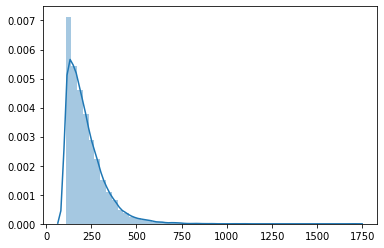

In [62]:
# Calculate mean of peak width
p_peaks = sorted_full_df['end'] - sorted_full_df['start']
sns.distplot(p_peaks)

(0.7974863783010937, 87.41189137458139, 97.7127068870126)
91.00009097978247
3006.4233909593236
219.12429343874828
15393.68518520732
124.07129073725041

108
1705
218.5376789553726
10728.262753181798
103.5773274089547


<AxesSubplot:>

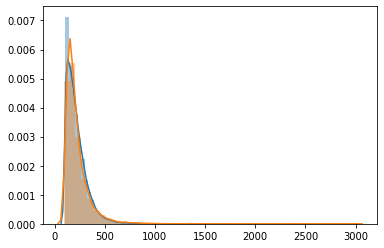

In [65]:
import scipy.stats as st
# def get_best_distribution(data):
#     dist_names = ["norm", "gamma","exponweib", "weibull_max", "weibull_min", "pareto", "genextreme", "lognorm"]
#     dist_results = []
#     params = {}
#     for dist_name in dist_names:
#         dist = getattr(st, dist_name)
#         param = dist.fit(data)
#
#         params[dist_name] = param
#         # Applying the Kolmogorov-Smirnov test
#         D, p = st.kstest(data, dist_name, args=param)
#         print("p value for "+dist_name+" = "+str(p))
#         dist_results.append((dist_name, p))
#
#     # select the best fitted distribution
#     best_dist, best_p = (min(dist_results, key=lambda item: item[1]))
#     # store the name of the best fit and its p value
#
#     print("Best fitting distribution: "+str(best_dist))
#     print("Best p value: "+ str(best_p))
#     print("Parameters for the best fit: "+ str(params[best_dist]))
#
#     return best_dist, best_p, params
#
# _, _, params = get_best_distribution(p_peaks)
parameters = stats.lognorm.fit(p_peaks, loc=0)
print(parameters)
sns.distplot(p_peaks)
gamma = stats.lognorm.rvs(parameters[0], parameters[1], parameters[2], size=10000)
print(gamma.min())
print(gamma.max())
print(gamma.mean())
print(gamma.var())
print(gamma.std())
print()
print(p_peaks.min())
print(p_peaks.max())
print(p_peaks.mean())
print(p_peaks.var())
print(p_peaks.std())

sns.distplot(gamma)

In [ ]:
peak_mean = p_peaks.mean()
peak_count = sorted_full_df.shape[1]
print(f'Positive peak mean: {peak_mean}')
print(f'Positive peak min: {p_peaks.min()}')
print(f'Positive peak max: {p_peaks.max()}')

# Calculate negative space
n_peaks = pd.DataFrame({'chr': sorted_full_df['chr'], 'start': sorted_full_df['end'].shift(1), 'end': sorted_full_df['start']}).dropna()
n_output_df = pd.DataFrame(columns=['chr','start','end','name','score','strand'])

np.random.seed(1)
random.seed(1)

peak_length_random = np.random.normal(loc = peak_mean, scale = 500, size = int(len(p_peaks)*1000)).astype(int)
peak_length_random = peak_length_random[peak_length_random > 10]
print(f'RANDOM {peak_length_random}')
print(f'RANDOM min {peak_length_random.min()}')
print(f'RANDOM max {peak_length_random.max()}')
counter = 0
for index, row in tqdm.tqdm(n_peaks.iterrows(), total=n_peaks.shape[0]):
    gap_length = row['end'] - row['start']
    peak_length = 0

    # Get peak length smaller than gap
    for _ in range(1000):
        peak_length = peak_length_random[counter]
        counter += 1
        if peak_length <= gap_length:
            break

    # Get start offset
    offset = 0
    try:
        offset = random.randint(0, int(gap_length - peak_length))
    except ValueError:
        continue

    # Add row to df
    row_start = row['start'] + offset

    n_output_df.loc[index] = [row['chr'], row_start, row_start + peak_length, 'n_peak', 1, '.']

# No digits
n_output_df[["start", "end"]] = n_output_df[["start", "end"]].astype(int)
# Sort
n_output_df = n_output_df.sort_values(['chr', 'start'])

print(f"MEAN {(n_output_df['end'] - n_output_df['start']).mean()}")
print(f"Length {len(n_output_df['start'])}")
n_output_df.to_csv(os.path.join(output_dir, 'negative_peak.bed'), index=False, header=False, sep='\t')